In [110]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance


In [111]:
def extrair_info_arquivo(nome):
    padrao = r"posicao_(\d+)_distancia_(\d+\.?\d*)_e_(\d+)_t(\d+)"
    m = re.search(padrao, nome)
    if m:
        return {
            "posicao": int(m.group(1)),
            "distancia": float(m.group(2)),
            "repeticao": int(m.group(3)),
            "triplicata": int(m.group(4))
        }
    return None

def listar_arquivos_velocidade(velocidade, base_dir="Imagens"):
    pasta = os.path.join(base_dir, f"velocidade_{velocidade}")
    arquivos = sorted(os.listdir(pasta))
    registros = []
    for arq in arquivos:
        if arq.endswith(".png"):
            info = extrair_info_arquivo(arq)
            if info:
                info["arquivo"] = os.path.join(pasta, arq)
                registros.append(info)
    df = pd.DataFrame(registros)
    df = df.sort_values(by=["repeticao", "posicao", "triplicata"]).reset_index(drop=True)
    return df


In [112]:


def medir_deslocamento(imagem_ref_path, imagem_atual_path, pix_mm=None):
    # Carrega imagens em tons de cinza
    img_ref = cv2.imread(imagem_ref_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img_atual = cv2.imread(imagem_atual_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

    # Calcula deslocamento com Phase Correlation
    shift = cv2.phaseCorrelate(img_ref, img_atual)
    dx, dy = shift[0]  # dx = deslocamento em x, dy = deslocamento em y
    deslocamento_px = np.sqrt(dx**2 + dy**2)

    # Se pix_mm for fornecido, converte para mm
    deslocamento_mm = deslocamento_px * pix_mm if pix_mm else None

    return {
        "dx_px": dx,
        "dy_px": dy,
        "deslocamento_px": deslocamento_px,
        "deslocamento_mm": deslocamento_mm
    }




def calcular_deslocamento(df):
    resultados = []
    centros = {}

    # === Detecta centro do quadrado em todas as imagens ===
    for _, linha in df.iterrows():
        centro = detectar_centro_quadrado(linha["arquivo"])
        if centro:
            centros[(linha["repeticao"], linha["posicao"], linha["triplicata"])] = {
                "centro": centro,
                "distancia": linha["distancia"]
            }

    # === Calcula o centro médio da primeira repetição (referência) ===
    centros_ref = []
    for (rep, pos, trip), dados in centros.items():
        if rep == 0 and pos == 0:  # só posição inicial da primeira repetição
            centros_ref.append(dados["centro"])

    if not centros_ref:
        raise ValueError("Não foi possível determinar o centro de referência da primeira repetição.")

    ref_x = np.mean([c[0] for c in centros_ref])
    ref_y = np.mean([c[1] for c in centros_ref])
    centro_ref = (ref_x, ref_y)

    p1 = np.array([100,120])
    p2 = np.array([250,117])

    pix_mm=21.6/np.linalg.norm(p1 - p2)

    # === Calcula deslocamento relativo à referência ===
    for (rep, pos, trip), dados in centros.items():
        if pos == 0:  # só mede em uma das posições (por exemplo, posição 0)
            cx, cy = dados["centro"]
            dx = cx - centro_ref[0]
            dy = cy - centro_ref[1]
            deslocamento = np.sqrt(dx**2 + dy**2)
            resultados.append({
                "repeticao": rep,
                "triplicata": trip,
                "dx": dx,
                "dy": dy,
                "deslocamento_px": deslocamento,
                "deslocamento_mm": deslocamento**pix_mm,
                "distancia_teorica": dados["distancia"]
            })

    # === Monta DataFrame ordenado ===
    df_new = pd.DataFrame(resultados)
    df_new = df_new.sort_values(by=["distancia_teorica", "repeticao", "triplicata"]).reset_index(drop=True)
    return df_new


In [113]:
def medir_deslocamento(imagem_ref_path, imagem_atual_path, pix_mm=None):
    # Carrega imagens em tons de cinza
    img_ref = cv2.imread(imagem_ref_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img_atual = cv2.imread(imagem_atual_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

    # Calcula deslocamento com Phase Correlation
    shift = cv2.phaseCorrelate(img_ref, img_atual)
    dx, dy = shift[0]  # dx = deslocamento em x, dy = deslocamento em y
    deslocamento_px = np.sqrt(dx**2 + dy**2)

    # Converte para mm se fornecido pix_mm
    deslocamento_mm = deslocamento_px * pix_mm if pix_mm else None

    return dx, dy, deslocamento_px, deslocamento_mm

def calcular_deslocamento_phase(df):
    resultados = []

    # === Define fator de conversão pixel → mm ===
    p1 = np.array([100, 120])
    p2 = np.array([250, 117])
    pix_mm = 21.6 / np.linalg.norm(p1 - p2)

    # === Define referências por posição ===
    referencias = {}
    for pos in df["posicao"].unique():
        df_ref = df[(df["repeticao"] == 0) & (df["posicao"] == pos)].sort_values(by=["triplicata"]).iloc[0]
        referencias[pos] = df_ref["arquivo"]

    # === Calcula deslocamentos ===
    for _, linha in df.iterrows():
        print(_, len(df), end='\r')  # mantido do seu código original
        imagem_ref = referencias[linha["posicao"]]  # referência específica da posição
        dx, dy, deslocamento_px, deslocamento_mm = medir_deslocamento(imagem_ref, linha["arquivo"], pix_mm)
        resultados.append({
            "posicao": linha["posicao"],
            "distancia_teorica": linha["distancia"],
            "repeticao": linha["repeticao"],
            "triplicata": linha["triplicata"],
            "dx_px": dx,
            "dy_px": dy,
            "deslocamento_px": deslocamento_px,
            "deslocamento_mm": deslocamento_mm
        })

    # === Monta DataFrame ordenado ===
    df_new = pd.DataFrame(resultados)
    df_new = df_new.sort_values(by=["distancia_teorica", "repeticao", "triplicata"]).reset_index(drop=True)
    return df_new




def plotar_todos_deslocamentos(df, velocidade):
    # Posições conhecidas para calibração pixel → mm
    p1 = np.array([100, 120])
    p2 = np.array([250, 117])

    # Fator de conversão de pixel para milímetro
    pix_mm = 21.6 / np.linalg.norm(p1 - p2)

    cores = {0: "blue", 1: "red"}

    # Cria subplots: 3 linhas, 1 coluna
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # Loop sobre as posições de referência (0 e 1)
    for pos_ref in [0, 1]:
        # Calcula média de dx e dy na posição de referência
        ref_dx = df[df["posicao"] == pos_ref]["dx_px"].mean()
        ref_dy = df[df["posicao"] == pos_ref]["dy_px"].mean()

        # Corrige deslocamentos relativos à referência
        df[f"dx_corrigido_{pos_ref}"] = (df["dx_px"] - ref_dx) * pix_mm
        df[f"dy_corrigido_{pos_ref}"] = (df["dy_px"] - ref_dy) * pix_mm
        df[f"desloc_corrigido_{pos_ref}"] = np.sqrt(
            df[f"dx_corrigido_{pos_ref}"]**2 + df[f"dy_corrigido_{pos_ref}"]**2
        )

        # Agrupa por distância teórica
        agrupado = df.groupby("distancia_teorica").agg(
            media_dx=(f"dx_corrigido_{pos_ref}", "mean"),
            desvio_dx=(f"dx_corrigido_{pos_ref}", "std"),
            media_dy=(f"dy_corrigido_{pos_ref}", "mean"),
            desvio_dy=(f"dy_corrigido_{pos_ref}", "std"),
            media_desloc=(f"desloc_corrigido_{pos_ref}", "mean"),
            desvio_desloc=(f"desloc_corrigido_{pos_ref}", "std")
        ).reset_index()

        # Plota dx
        axs[0].errorbar(
            agrupado["distancia_teorica"]/1000,  # converte mm → m
            agrupado["media_dx"],
            yerr=agrupado["desvio_dx"],
            fmt='o-',
            capsize=5,
            color=cores[pos_ref],
            label=f"dx - posição {pos_ref}"
        )

        # Plota dy
        axs[1].errorbar(
            agrupado["distancia_teorica"]/1000,
            agrupado["media_dy"],
            yerr=agrupado["desvio_dy"],
            fmt='o-',
            capsize=5,
            color=cores[pos_ref],
            label=f"dy - posição {pos_ref}"
        )

        # Plota deslocamento euclidiano
        axs[2].errorbar(
            agrupado["distancia_teorica"]/1000,
            agrupado["media_desloc"],
            yerr=agrupado["desvio_desloc"],
            fmt='o-',
            capsize=5,
            color=cores[pos_ref],
            label=f"euclidiano - posição {pos_ref}"
        )

    # Configurações gerais
    axs[0].set_ylabel("Erro dx (mm)")
    axs[0].grid(True)
    axs[0].legend()
    axs[0].set_title("Erro em dx")

    axs[1].set_ylabel("Erro dy (mm)")
    axs[1].grid(True)
    axs[1].legend()
    axs[1].set_title("Erro em dy")

    axs[2].set_ylabel("Deslocamento (mm)")
    axs[2].set_xlabel("Distância movimentada (m)")
    axs[2].grid(True)
    axs[2].legend()
    axs[2].set_title("Deslocamento euclidiano")

    plt.suptitle(f"Deslocamentos em relação às posições 0 e 1 - Velocidade {velocidade} mm/min", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [114]:
def analisar_deslocamento_velocidade(velocidade, base_dir="Imagens"):
    df_arquivos = listar_arquivos_velocidade(velocidade, base_dir)
    df_deslocamento = calcular_deslocamento_phase(df_arquivos)
    plotar_todos_deslocamentos(df_deslocamento, velocidade)
    return df_deslocamento


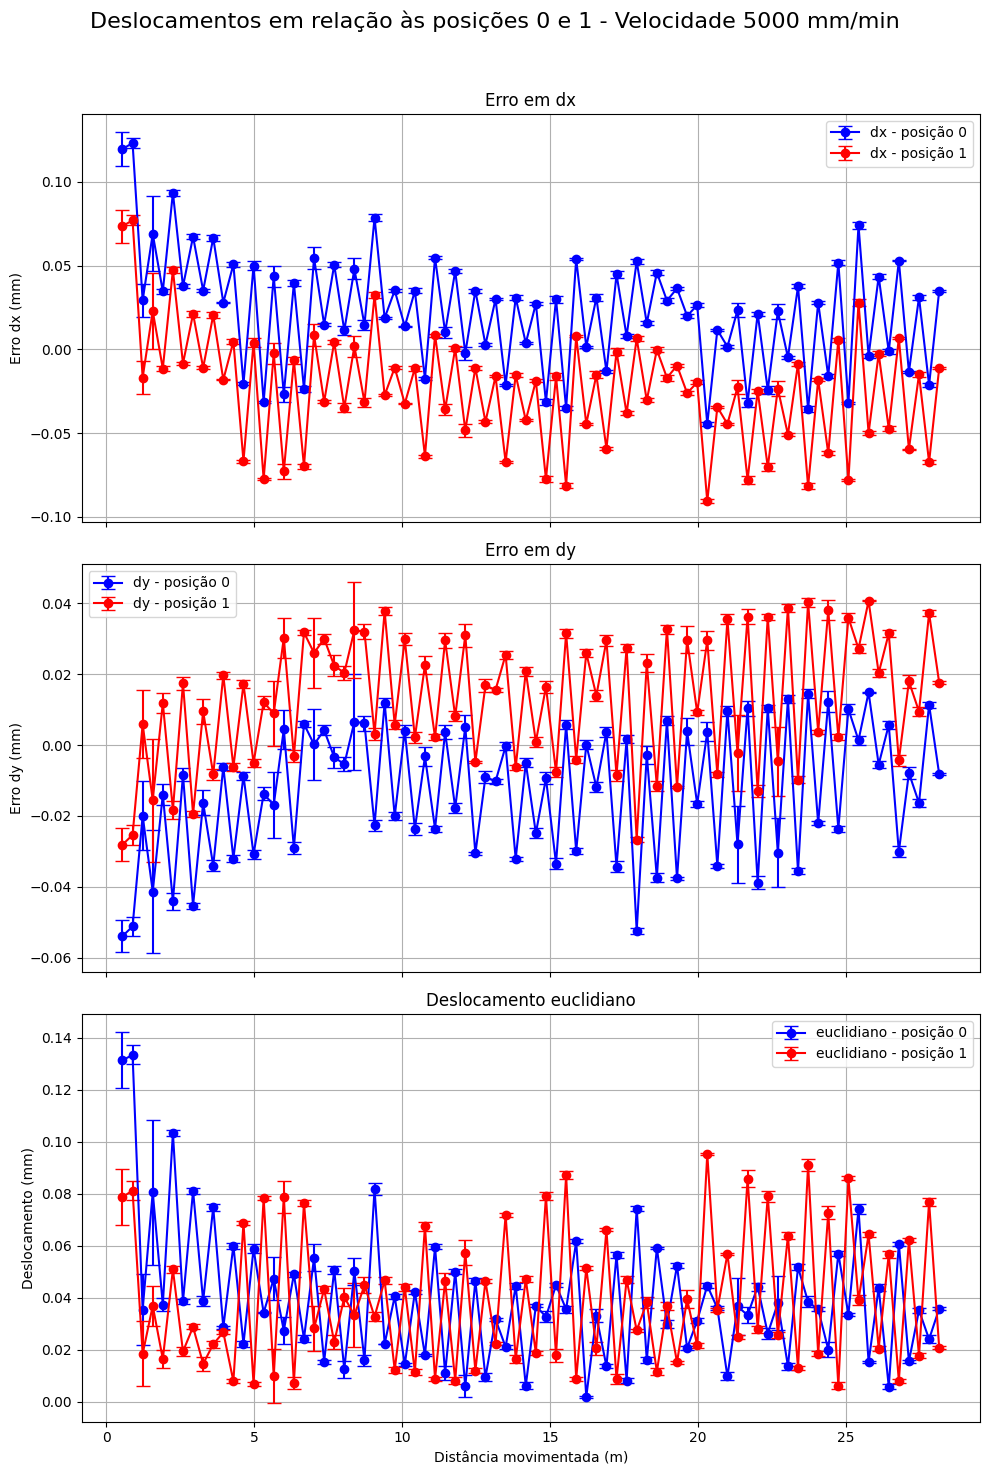

In [115]:
dados_5000 = analisar_deslocamento_velocidade(5000)


In [116]:
dados_5000

,posicao,distancia_teorica,repeticao,triplicata,dx_px,dy_px,deslocamento_px,deslocamento_mm,dx_corrigido_0,dy_corrigido_0,desloc_corrigido_0,dx_corrigido_1,dy_corrigido_1,desloc_corrigido_1
0,0,552.79,0,0,0.000000,0.000000,0.000000,0.000000,0.126196,-0.054591,0.137497,0.080101,-0.028776,0.085113
1,0,552.79,0,1,-0.011070,-0.024290,0.026694,0.003843,0.124602,-0.058088,0.137477,0.078507,-0.032273,0.084882
2,0,552.79,0,2,-0.124151,0.038737,0.130054,0.018724,0.108321,-0.049014,0.118895,0.062227,-0.023199,0.066411
3,1,893.38,0,0,0.000000,0.000000,0.000000,0.000000,0.126196,-0.054591,0.137497,0.080101,-0.028776,0.085113
4,1,893.38,0,1,-0.015662,0.007688,0.017447,0.002512,0.123941,-0.053484,0.134988,0.077846,-0.027669,0.082617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,0,27799.99,40,1,-1.015182,0.454058,1.112098,0.160110,-0.019961,0.010780,0.022686,-0.066056,0.036595,0.075516
322,0,27799.99,40,2,-1.031984,0.465214,1.131996,0.162975,-0.022380,0.012386,0.025579,-0.068475,0.038201,0.078410
323,1,28140.58,40,0,-0.632954,0.324770,0.711412,0.102423,0.035068,-0.007834,0.035933,-0.011026,0.017981,0.021093
324,1,28140.58,40,1,-0.630268,0.319761,0.706743,0.101751,0.035455,-0.008555,0.036473,-0.010640,0.017260,0.020276


In [117]:
nomes_arquivos = listar_arquivos_velocidade(1000)

In [118]:
nomes_arquivos

,posicao,distancia,repeticao,triplicata,arquivo
0,0,552.79,0,0,Imagens/velocidade_1000/posicao_0_distancia_55...
1,0,552.79,0,1,Imagens/velocidade_1000/posicao_0_distancia_55...
2,0,552.79,0,2,Imagens/velocidade_1000/posicao_0_distancia_55...
3,1,893.38,0,0,Imagens/velocidade_1000/posicao_1_distancia_89...
4,1,893.38,0,1,Imagens/velocidade_1000/posicao_1_distancia_89...
...,...,...,...,...,...
1607,1,137129.38,200,4,Imagens/velocidade_1000/posicao_1_distancia_13...
1608,0,137469.97,201,0,Imagens/velocidade_1000/posicao_0_distancia_13...
1609,0,137469.97,201,1,Imagens/velocidade_1000/posicao_0_distancia_13...
1610,0,137469.97,201,2,Imagens/velocidade_1000/posicao_0_distancia_13...
